## Predictor variable selection ## 

#### forward selection (Eforymson 1966; Draper and Smith 1966) ####

Iteratively build up a model by adding one predictor variable at a time, starting one with no predictors.

Run the following 3 steps until you run out of predictors:
1. For each unused predictor, add it to the model to form a candidate model.
2. Tune all of the candidate models.
3. Update the model to be the candidate model with the highest cross-validation accuracy.

Select the model that provides the best trade-off between accuracy and simplicity.

### set-up ###

In [1]:
# loading packages
library(repr)
library(tidyverse)
library(tidymodels)
# library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# loading data
stroke <- read_csv("data/stroke-data.csv")
colnames(stroke)

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)



[1] "id"                "gender"            "age"              
 [4] "hypertension"      "heart_disease"     "ever_married"     
 [7] "work_type"         "Residence_type"    "avg_glucose_level"
[10] "bmi"               "smoking_status"    "stroke"

In [3]:
# cleaning and wrangling
# stroke_clean <- stroke %>%
#     select(gender, age, hypertension, heart_disease, avg_glucose_level, bmi, smoking_status, stroke) %>%
#     mutate(gender = as_factor(gender), 
#            bmi = as.numeric(bmi),
#            smoking_status = as_factor(smoking_status),
#            stroke = as_factor(stroke)) %>%
#     filter(gender != "Other") #Other was removed as there was only one occurrence in the dataset

# prep and bake data with upsampling, then use it with everything
# gonna overfit data, data leakage
stroke_clean <- stroke %>%
    select(age, hypertension, heart_disease, avg_glucose_level, bmi, stroke) %>%
    mutate(stroke = as_factor(stroke),
           bmi = as.numeric(bmi)) 

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [4]:
head(stroke_clean)

age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,0,1,228.69,36.6,1
61,0,0,202.21,NA,1
80,0,1,105.92,32.5,1
49,0,0,171.23,34.4,1
79,1,0,174.12,24.0,1
81,0,0,186.21,29.0,1


In [5]:
# library(themis)
ups_recipe <- recipe(stroke ~ ., data = stroke_clean) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_upsample(stroke, over_ratio = 1, skip = FALSE) %>%
    prep()

upsampled_stroke <- bake(ups_recipe, stroke_clean)

upsampled_stroke %>%
  group_by(stroke) %>%
  summarize(n = n())

head(upsampled_stroke)
tail(upsampled_stroke)
stroke_clean <- upsampled_stroke

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
`summarise()` ungrouping output (override with `.groups` argument)



stroke,n
<fct>,<int>
0,4861
1,4861


age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.7789432,-0.3285697,-0.2389234,-0.2435250,-1.3869550,0
0.6533240,3.0428986,-0.2389234,-0.4016397,1.3122836,0
-1.5578280,-0.3285697,-0.2389234,0.1047250,-1.4378840,0
1.1840005,-0.3285697,-0.2389234,-0.8194514,0.8921191,0
-1.2924898,-0.3285697,-0.2389234,1.2174909,-1.2469001,0
0.1668706,-0.3285697,-0.2389234,2.3143570,2.7000997,0


age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.1397775,3.0428986,4.1846225,-0.7503314,1.00670944,1
0.6975471,-0.3285697,-0.2389234,-0.6624408,NA,1
0.0784245,-0.3285697,-0.2389234,-0.9276584,0.06452238,1
0.2110936,-0.3285697,-0.2389234,-0.4846721,0.10271915,1
0.9628853,-0.3285697,-0.2389234,-0.8329221,NA,1
1.7146770,-0.3285697,4.1846225,2.2558368,0.45922236,1


### start ### DONT RUN THINGS IN THIS SECTION (skip to 'with predict')

In [6]:
stroke_subset <- upsampled_stroke %>%
    filter(!is.na(bmi))
names <- colnames(stroke_clean %>% select(-stroke)) %>% sort()
names

[1] "age"               "avg_glucose_level" "bmi"              
[4] "heart_disease"     "hypertension"

In [7]:
example_formula <- paste("stroke", "~", paste(names, collapse="+"))
example_formula

[1] "stroke ~ age+avg_glucose_level+bmi+heart_disease+hypertension"

In [174]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


In [175]:
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
stroke_vfold <- vfold_cv(stroke_subset, v = 5, strata = stroke)

gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 2))

In [176]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

In [8]:
set.seed(31)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    print("start")
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        print(model_string)
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

#         !!! how can i repeat the below step more to make it more accurate?
        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = gridvals) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    print("unlist")
    print(unlist(accs))
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}


ERROR: Error in eval(expr, envir, enclos): object 'n_total' not found


In [178]:
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,stroke ~ avg_glucose_level,0.9387171
2,stroke ~ avg_glucose_level+age,0.9744559
3,stroke ~ avg_glucose_level+age+heart_disease,0.9741123
4,stroke ~ avg_glucose_level+age+heart_disease+hypertension,0.9749141
5,stroke ~ avg_glucose_level+age+heart_disease+hypertension+bmi,0.9737686


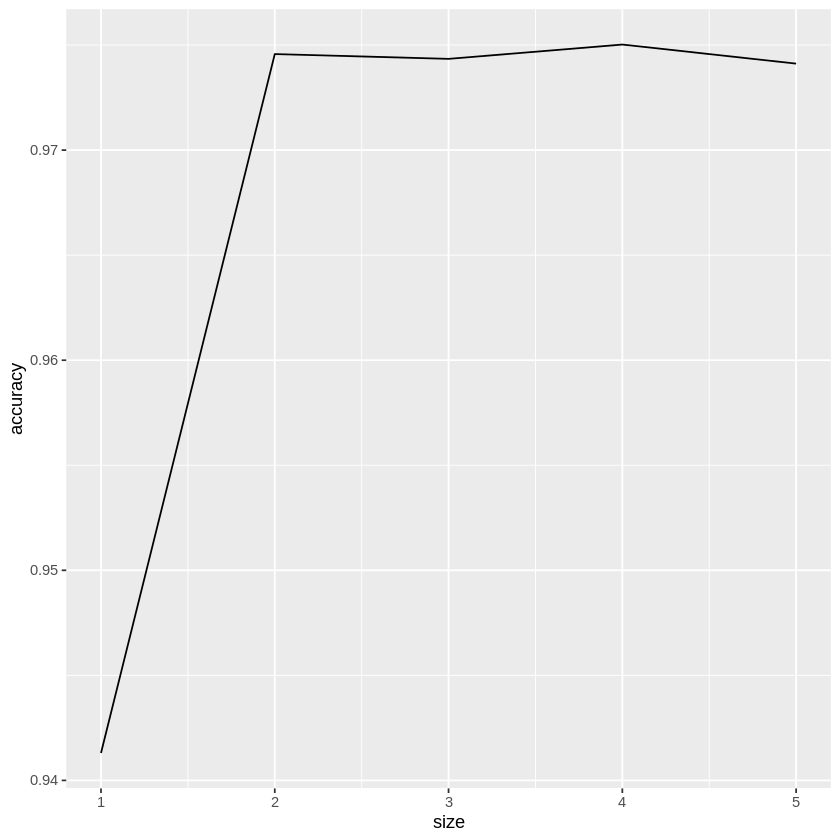

In [165]:
ggplot(accuracies, aes(x=size, y=accuracy)) +
geom_line()

## with predict ##

In [19]:
# data splitting
set.seed(31)

stroke_split <- initial_split(upsampled_stroke, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

In [20]:
stroke_recipe <- recipe(stroke ~ avg_glucose_level + hypertension, data = stroke_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

In [21]:
stroke_vfold <- vfold_cv(stroke_train, v = 5, strata = stroke)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

In [22]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

In [23]:
knn_results <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = stroke_vfold, grid = k_vals) %>%
  collect_metrics() 
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9223808,5,0.0008479548,Model01
1,roc_auc,binary,0.9223808,5,0.0008479548,Model01
2,accuracy,binary,0.9226576,5,0.0037122146,Model02
2,roc_auc,binary,0.9555307,5,0.0021515454,Model02
3,accuracy,binary,0.9258104,5,0.0031155363,Model03
3,roc_auc,binary,0.9546790,5,0.0015471547,Model03
4,accuracy,binary,0.9258105,5,0.0033682530,Model04
4,roc_auc,binary,0.9536289,5,0.0018918386,Model04
5,accuracy,binary,0.8994797,5,0.0036403344,Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,accuracy,binary,0.9258105,5,0.003368253,Model04


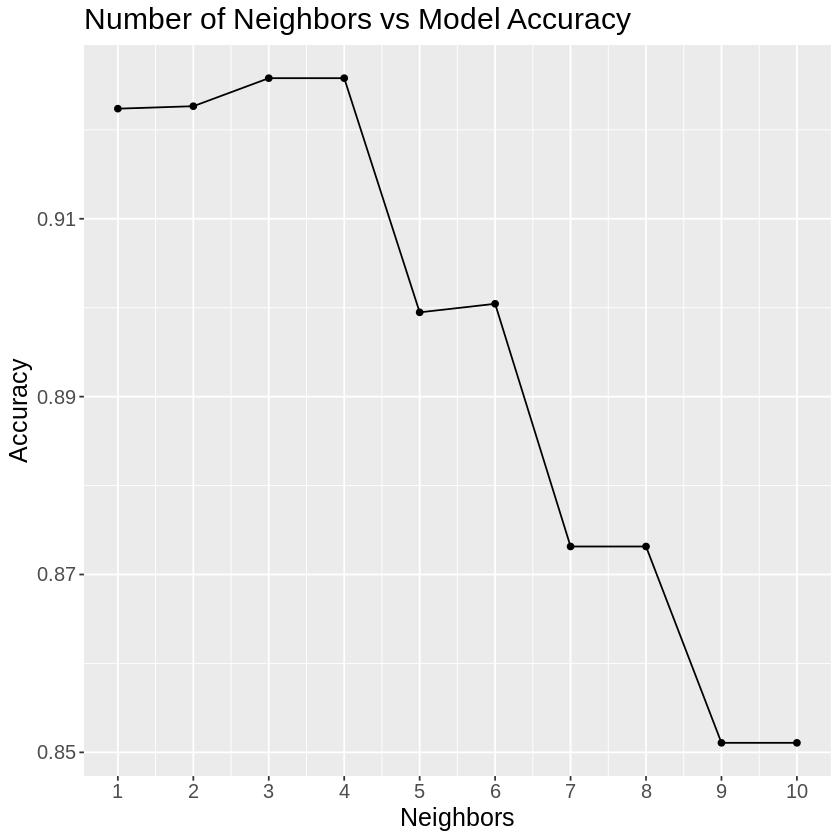

In [27]:
accuracies <- knn_results %>% # Plot accuracies vs neighbours
  filter(.metric == "accuracy")

# This plot 
accuracies_vs_ks <- accuracies %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Number of Neighbors vs Model Accuracy") +
    labs(x="Neighbors", y="Accuracy") +
    theme(text = element_text(size=15)) +
    scale_x_continuous(breaks=c(1:10))

accuracies_vs_ks

# This is the optimal number of neighbors, found by determining the max accuracy 

optimal_neighbours <- accuracies %>%
  filter(mean == max(mean))
optimal_neighbours

## Model Construction ##

In [31]:
stroke_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
  set_engine("kknn") %>%
  set_mode("classification")

stroke_recipe <- recipe(stroke ~ avg_glucose_level + hypertension, data = stroke_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

stroke_fit <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(stroke_spec) %>%
  fit(data = stroke_train)
stroke_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~4, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05869446
Best kernel: rectangular
Best k: 4

## Test Set Prediction ##

In [36]:
stroke_test_predictions <- predict(stroke_fit, stroke_test) %>%
  bind_cols(stroke_test)

stroke_test_accuracies <- stroke_test_predictions %>%
  metrics(truth = stroke, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

stroke_test_accuracies


stroke_confusion_mat <- stroke_test_predictions %>%
             conf_mat(truth = stroke, estimate = .pred_class)

stroke_confusion_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9403292


          Truth
Prediction    0    1
         0 1074    4
         1  141 1211

### Performance Analysis ###

For this model, an accuracy of 94.03292% was achieved.

When observing the confusion matrix for the model's classification of test data, we see that type 1 error is much more prevalent, meaning false positives are assigned to patients who in reality will not experience a stroke. On the other hand, type 2 error is very low. In the case of preventative medicine, which is the aim of this classifier, false positives are much less serious than false negatives as it will simply mean patients will likel taking further precautions to prevent stroke occurance. 

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies